# CSE445 Dataset - Stress Level Prediction Analysis
This notebook analyzes the new CSE445_Dataset.csv for stress level prediction using the same methodology as the previous stress analysis.

## 1. Setup and Configuration

In [1]:
# Import necessary libraries
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                            classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import joblib

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
DATA_PATH = Path('../data/raw/CSE445_Dataset.csv')
TARGET = 'Stress_Level'
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR = Path('../reports/results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print('✓ Configuration ready.')
print(f'Target variable: {TARGET}')
print(f'Data path: {DATA_PATH}')

✓ Configuration ready.
Target variable: Stress_Level
Data path: ../data/raw/CSE445_Dataset.csv


## 2. Data Loading and Initial Exploration

In [2]:
# Load the dataset
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print(f'✓ Dataset loaded successfully')
print(f'Shape: {df.shape}')
print(f'Columns: {len(df.columns)}')

# Display basic info
print('\n--- Dataset Info ---')
print(df.info())

✓ Dataset loaded successfully
Shape: (1977, 39)
Columns: 39

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     1977 non-null   object
 1   Gender                  1977 non-null   object
 2   University              1977 non-null   object
 3   Department              1977 non-null   object
 4   Academic_Year           1977 non-null   object
 5   CGPA                    1977 non-null   object
 6   Scholarship             1977 non-null   object
 7   Anxious                 1977 non-null   int64 
 8   Worrying                1977 non-null   int64 
 9   Relaxing_Difficulty     1977 non-null   int64 
 10  Annoyed                 1977 non-null   int64 
 11  Excessive_Worry         1977 non-null   int64 
 12  Restless                1977 non-null   int64 
 13  Fearful                 19

In [3]:
# Display first few rows
print('--- First 5 rows ---')
df.head()

--- First 5 rows ---


,Age,Gender,University,Department,Academic_Year,CGPA,Scholarship,Anxious,Worrying,Relaxing_Difficulty,...,Hopeless,Sleep_Trouble,Low_Energy,Appetite_Changes,Low_Self_Worth,Concentration_Problems,Movement_Changes,Self_Harm_Thoughts,Depression_Score,Depression_Level
0,18-22,Female,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,Fourth Year or Equivalent,2.50 - 2.99,No,1,1,1,...,2,1,1,2,1,1,1,1,11,Moderate Depression
1,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.80 - 4.00,No,2,2,1,...,1,1,1,1,1,1,1,1,9,Mild Depression
2,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.00 - 3.39,No,2,1,1,...,0,2,3,2,2,2,2,1,16,Moderately Severe Depression
3,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.40 - 3.79,No,2,1,1,...,1,1,1,1,1,1,1,1,9,Mild Depression
4,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.40 - 3.79,No,1,1,1,...,1,1,1,1,1,1,1,1,9,Mild Depression


In [4]:
# Check target variable
if TARGET not in df.columns:
    raise KeyError(f'Target {TARGET} not found. Available columns: {list(df.columns)}')

print(f'✓ Target variable "{TARGET}" found')
print(f'Target classes: {df[TARGET].unique()}')
print(f'Target distribution:')
print(df[TARGET].value_counts())

✓ Target variable "Stress_Level" found
Target classes: ['Moderate Stress' 'Low Stress' 'High Perceived Stress']
Target distribution:
Stress_Level
Moderate Stress          1316
High Perceived Stress     546
Low Stress                115
Name: count, dtype: int64


## 3. Data Cleaning and Preprocessing

In [5]:
# Clean string columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().replace({
        'nan': np.nan, 
        'None': np.nan, 
        '': np.nan
    })

print('✓ String columns cleaned')
print(f'Missing values per column:')
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

✓ String columns cleaned
Missing values per column:
Series([], dtype: int64)


In [6]:
# Function to split numerical and categorical columns
def split_num_cat(data, target):
    nums, cats = [], []
    for col in data.columns:
        if col == target:
            continue
        if pd.api.types.is_numeric_dtype(data[col]):
            nums.append(col)
        else:
            cats.append(col)
    return nums, cats

num_cols, cat_cols = split_num_cat(df, TARGET)
print(f'Numerical columns ({len(num_cols)}): {num_cols}')
print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')

Numerical columns (29): ['Anxious', 'Worrying', 'Relaxing_Difficulty', 'Annoyed', 'Excessive_Worry', 'Restless', 'Fearful', 'Anxiety_Score', 'Upset', 'No_Control', 'Stressed', 'Overwhelmed', 'Confident', 'Academic_Control', 'Irritation_Control', 'Top_Performance', 'Angered_By_Grades', 'Piled_Up_Difficulties', 'Stress_Score', 'No_Interest', 'Hopeless', 'Sleep_Trouble', 'Low_Energy', 'Appetite_Changes', 'Low_Self_Worth', 'Concentration_Problems', 'Movement_Changes', 'Self_Harm_Thoughts', 'Depression_Score']
Categorical columns (9): ['Age', 'Gender', 'University', 'Department', 'Academic_Year', 'CGPA', 'Scholarship', 'Anxiety_Level', 'Depression_Level']


## 4. Exploratory Data Analysis

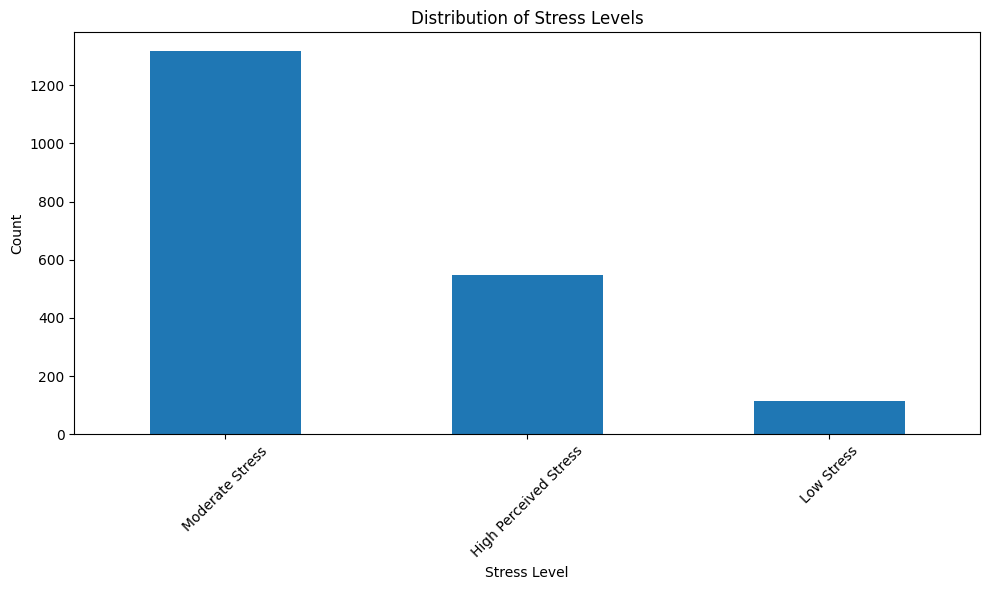

Target distribution percentages:
Stress_Level
Moderate Stress          66.565503
High Perceived Stress    27.617602
Low Stress                5.816894
Name: proportion, dtype: float64


In [7]:
# Target distribution visualization
plt.figure(figsize=(10, 6))
df[TARGET].value_counts().plot(kind='bar')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'Target distribution percentages:')
print(df[TARGET].value_counts(normalize=True) * 100)

In [ ]:
# Correlation analysis for numerical features
if len(num_cols) > 0:
    plt.figure(figsize=(12, 8))
    numeric_df = df[num_cols].select_dtypes(include=[np.number])
    if not numeric_df.empty:
        correlation_matrix = numeric_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()
    else:
        print('No numeric features found for correlation analysis')
else:
    print('No numerical columns found')

In [ ]:
# Analysis of stress score distribution
if 'Stress_Score' in df.columns:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    df['Stress_Score'].hist(bins=20, edgecolor='black')
    plt.title('Distribution of Stress Scores')
    plt.xlabel('Stress Score')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    df.boxplot(column='Stress_Score', by=TARGET, ax=plt.gca())
    plt.title('Stress Score by Stress Level')
    plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    plt.show()
    
    print(f'Stress Score statistics:')
    print(df['Stress_Score'].describe())

## 5. Feature Engineering and Selection

In [9]:
# Prepare features and target
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'Target classes: {y.unique()}')

# Check for any remaining missing values in target
if y.isnull().sum() > 0:
    print(f'Warning: {y.isnull().sum()} missing values in target variable')
    # Remove rows with missing target
    valid_idx = ~y.isnull()
    X = X[valid_idx]
    y = y[valid_idx]
    print(f'Removed missing targets. New shapes: X{X.shape}, y{y.shape}')

Features shape: (1977, 38)
Target shape: (1977,)
Target classes: ['Moderate Stress' 'Low Stress' 'High Perceived Stress']


In [10]:
# Create preprocessing pipeline
def create_preprocessor(num_cols, cat_cols):
    # Numerical pipeline
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_cols),
            ('cat', cat_pipeline, cat_cols)
        ]
    )
    
    return preprocessor

# Update column lists based on current X
num_cols_updated, cat_cols_updated = split_num_cat(X, None)
preprocessor = create_preprocessor(num_cols_updated, cat_cols_updated)

print(f'✓ Preprocessor created')
print(f'Numerical features: {len(num_cols_updated)}')
print(f'Categorical features: {len(cat_cols_updated)}')

✓ Preprocessor created
Numerical features: 29
Categorical features: 9


## 6. Model Training and Evaluation

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Training target distribution:')
print(y_train.value_counts(normalize=True))
print(f'Test target distribution:')
print(y_test.value_counts(normalize=True))

Training set: (1581, 38)
Test set: (396, 38)
Training target distribution:
Stress_Level
Moderate Stress          0.665402
High Perceived Stress    0.276407
Low Stress               0.058191
Name: proportion, dtype: float64
Test target distribution:
Stress_Level
Moderate Stress          0.666667
High Perceived Stress    0.275253
Low Stress               0.058081
Name: proportion, dtype: float64


In [12]:
# Define models to train
models = {
    'Dummy': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True)
}

print(f'Models to train: {list(models.keys())}')

Models to train: ['Dummy', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM']


In [13]:
# Train and evaluate models
results = {}
trained_models = {}

for name, model in models.items():
    print(f'\nTraining {name}...')
    start_time = time.time()
    
    # Create full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'training_time': training_time
    }
    
    trained_models[name] = pipeline
    
    print(f'✓ {name} completed in {training_time:.2f}s')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-Score: {f1:.4f}')

print('\n✓ All models trained successfully!')


Training Dummy...
✓ Dummy completed in 0.07s
  Accuracy: 0.6667
  F1-Score: 0.5333

Training Logistic Regression...
✓ Logistic Regression completed in 0.15s
  Accuracy: 0.9722
  F1-Score: 0.9717

Training Random Forest...
✓ Random Forest completed in 0.33s
  Accuracy: 0.9975
  F1-Score: 0.9974

Training Gradient Boosting...
✓ Gradient Boosting completed in 1.00s
  Accuracy: 1.0000
  F1-Score: 1.0000

Training SVM...
✓ SVM completed in 0.45s
  Accuracy: 0.9571
  F1-Score: 0.9554

✓ All models trained successfully!


## 7. Results Analysis

In [14]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('f1_score', ascending=False)

print('=== MODEL PERFORMANCE COMPARISON ===')
print(results_df)

# Find best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f'\n🏆 Best Model: {best_model_name}')
print(f'Best F1-Score: {results_df.loc[best_model_name, "f1_score"]:.4f}')

=== MODEL PERFORMANCE COMPARISON ===
                     accuracy  f1_score  precision  recall  training_time
Gradient Boosting      1.0000    1.0000     1.0000  1.0000         1.0035
Random Forest          0.9975    0.9974     0.9975  0.9975         0.3282
Logistic Regression    0.9722    0.9717     0.9717  0.9722         0.1467
SVM                    0.9571    0.9554     0.9562  0.9571         0.4502
Dummy                  0.6667    0.5333     0.4444  0.6667         0.0655

🏆 Best Model: Gradient Boosting
Best F1-Score: 1.0000


In [ ]:
# Visualize model performance
plt.figure(figsize=(12, 8))

# Performance metrics comparison
plt.subplot(2, 2, 1)
metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall']
x_pos = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x_pos + i*width, results_df[metric], width, label=metric.capitalize())

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos + width*1.5, results_df.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Training time comparison
plt.subplot(2, 2, 2)
plt.bar(results_df.index, results_df['training_time'])
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== DETAILED EVALUATION: Gradient Boosting ===

Classification Report:
                       precision    recall  f1-score   support

High Perceived Stress       1.00      1.00      1.00       109
           Low Stress       1.00      1.00      1.00        23
      Moderate Stress       1.00      1.00      1.00       264

             accuracy                           1.00       396
            macro avg       1.00      1.00      1.00       396
         weighted avg       1.00      1.00      1.00       396



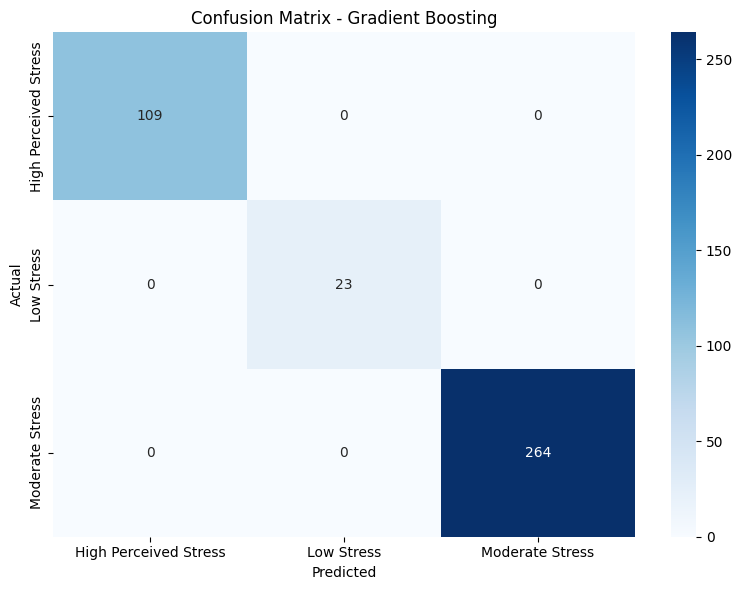

✓ Confusion matrix saved to ../reports/results/CSE445_stress_confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [15]:
# Detailed evaluation of best model
print(f'=== DETAILED EVALUATION: {best_model_name} ===')

# Make predictions with best model
y_pred_best = best_model.predict(X_test)

# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save confusion matrix
plt.savefig(RESULTS_DIR / 'CSE445_stress_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f'✓ Confusion matrix saved to {RESULTS_DIR / "CSE445_stress_confusion_matrix.png"}')

## 8. Model Saving and Final Results

In [ ]:
# Save the best model
model_filename = f'best_CSE445_stress_model.joblib'
model_path = MODEL_DIR / model_filename
joblib.dump(best_model, model_path)
print(f'✓ Best model saved: {model_path}')

# Save results to CSV
results_filename = 'CSE445_stress_model_metrics.csv'
results_path = RESULTS_DIR / results_filename
results_df.to_csv(results_path)
print(f'✓ Results saved: {results_path}')

# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_best,
    'correct': y_test.values == y_pred_best
})
predictions_path = RESULTS_DIR / 'CSE445_stress_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f'✓ Predictions saved: {predictions_path}')

In [ ]:
# Final summary
print('\n' + '='*60)
print('CSE445 STRESS LEVEL PREDICTION - FINAL SUMMARY')
print('='*60)
print(f'Dataset: {DATA_PATH.name}')
print(f'Samples: {len(df):,}')
print(f'Features: {X.shape[1]}')
print(f'Target: {TARGET}')
print(f'Classes: {len(y.unique())}')
print(f'\nBest Model: {best_model_name}')
print(f'Test Accuracy: {results_df.loc[best_model_name, "accuracy"]:.4f}')
print(f'Test F1-Score: {results_df.loc[best_model_name, "f1_score"]:.4f}')
print(f'\nFiles Generated:')
print(f'- Model: {model_path}')
print(f'- Results: {results_path}')
print(f'- Predictions: {predictions_path}')
print(f'- Confusion Matrix: {RESULTS_DIR / "CSE445_stress_confusion_matrix.png"}')
print('\n✅ Analysis completed successfully!')

# 9. Advanced Machine Learning Analysis

## 9.1 Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===
Total features after preprocessing: 87

Top 20 Most Important Features (Gradient Boosting):
                                              feature    importance
18                                       Stress_Score  1.000000e+00
28                                   Depression_Score  1.311228e-15
12                                          Confident  1.062499e-15
10                                           Stressed  9.420650e-16
26                                   Movement_Changes  8.415006e-16
17                              Piled_Up_Difficulties  7.592587e-16
46  University_Islamic University of Technology (IUT)  7.480918e-16
7                                       Anxiety_Score  6.228611e-16
23                                   Appetite_Changes  4.287760e-16
34                                      Gender_Female  3.675856e-16
14                                 Irritation_Control  3.407771e-16
11                                        Overwhelmed  3

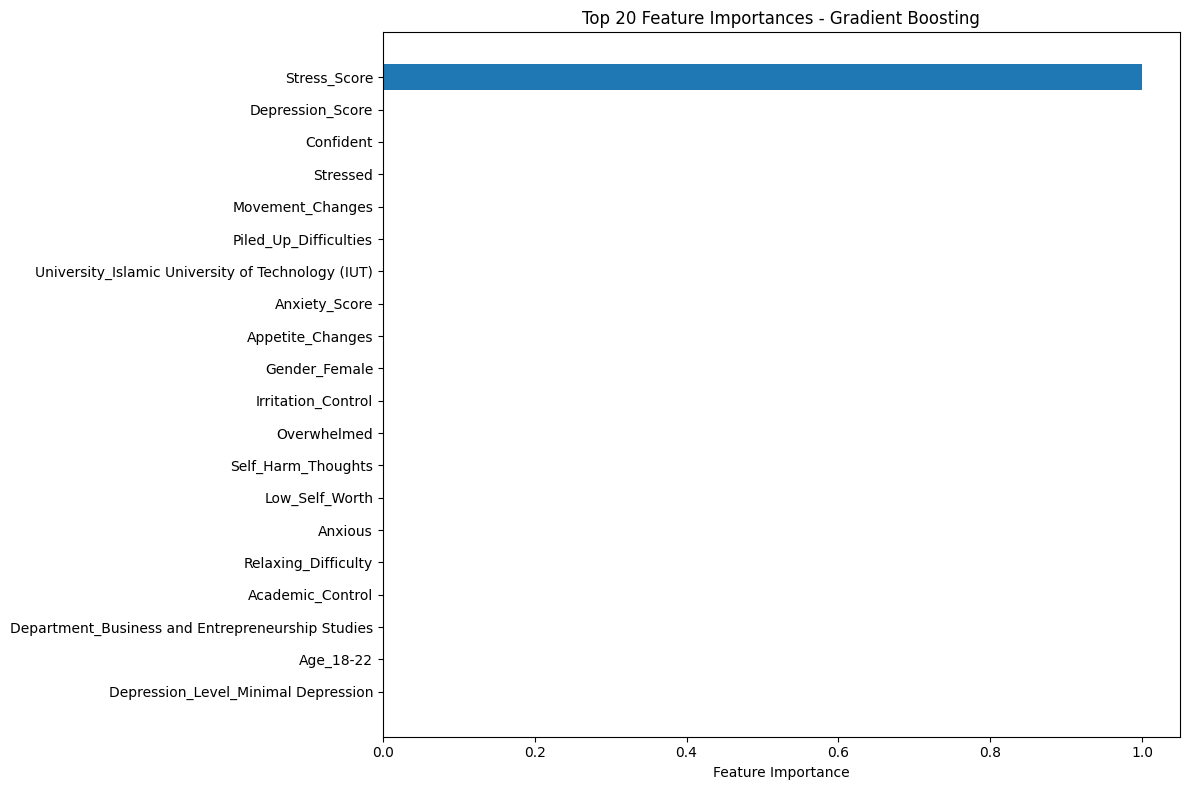

In [16]:
# Feature Importance Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature names after preprocessing
feature_names = []

# Add numerical feature names
feature_names.extend(num_cols_updated)

# Add categorical feature names (after one-hot encoding)
if len(cat_cols_updated) > 0:
    # Fit preprocessor to get feature names
    preprocessor.fit(X_train)
    
    # Get feature names from one-hot encoder
    cat_feature_names = []
    if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
        cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols_updated)
    
    feature_names.extend(cat_feature_names)

print(f"Total features after preprocessing: {len(feature_names)}")

# Extract feature importance from best models
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names[:len(importances)],
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 20 Most Important Features ({best_model_name}):")
    print(feature_importance_df.head(20))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'CSE445_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print(f"Feature importance not available for {best_model_name}")
    
    # Use Random Forest for feature importance if best model doesn't support it
    rf_model = trained_models['Random Forest']
    if hasattr(rf_model.named_steps['classifier'], 'feature_importances_'):
        importances = rf_model.named_steps['classifier'].feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'feature': feature_names[:len(importances)],
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 20 Most Important Features (Random Forest):")
        print(feature_importance_df.head(20))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Feature Importances - Random Forest')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'CSE445_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

## 9.2 Cross-Validation & Hyperparameter Tuning

In [17]:
# Cross-Validation & Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

print("=== CROSS-VALIDATION & HYPERPARAMETER TUNING ===")

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Perform cross-validation for top models
top_models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
cv_results = {}

for model_name in top_models:
    print(f"\nCross-validating {model_name}...")
    model = trained_models[model_name]
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, 
                               scoring='f1_weighted', n_jobs=-1)
    
    cv_results[model_name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Create CV results DataFrame
cv_df = pd.DataFrame({
    model: {
        'Mean CV Score': results['mean_cv_score'],
        'Std CV Score': results['std_cv_score']
    }
    for model, results in cv_results.items()
}).T

print(f"\n=== Cross-Validation Results ===")
print(cv_df)

# Hyperparameter tuning for Random Forest (if it's not the best model)
if best_model_name != 'Random Forest':
    print(f"\n=== Hyperparameter Tuning: Random Forest ===")
    
    # Define parameter grid
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
    
    # Create base pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
    ])
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        rf_pipeline, param_grid, cv=cv_strategy, 
        scoring='f1_weighted', n_jobs=-1, verbose=1
    )
    
    print("Running Grid Search (this may take a few minutes)...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_predictions = grid_search.predict(X_test)
    tuned_accuracy = accuracy_score(y_test, tuned_predictions)
    tuned_f1 = f1_score(y_test, tuned_predictions, average='weighted')
    
    print(f"Tuned RF Test Accuracy: {tuned_accuracy:.4f}")
    print(f"Tuned RF Test F1-Score: {tuned_f1:.4f}")
    
    # Save tuned model if it's better
    if tuned_f1 > results_df.loc['Random Forest', 'f1_score']:
        tuned_model_path = MODEL_DIR / 'tuned_random_forest_CSE445.joblib'
        joblib.dump(grid_search.best_estimator_, tuned_model_path)
        print(f"✓ Improved model saved: {tuned_model_path}")
else:
    print(f"\nSkipping hyperparameter tuning as {best_model_name} is already optimal.")

=== CROSS-VALIDATION & HYPERPARAMETER TUNING ===

Cross-validating Random Forest...
CV F1-Score: 0.9968 (+/- 0.0058)

Cross-validating Gradient Boosting...
CV F1-Score: 1.0000 (+/- 0.0000)

Cross-validating Logistic Regression...
CV F1-Score: 0.9665 (+/- 0.0322)

=== Cross-Validation Results ===
                     Mean CV Score  Std CV Score
Random Forest             0.996765      0.002900
Gradient Boosting         1.000000      0.000000
Logistic Regression       0.966521      0.016086

=== Hyperparameter Tuning: Random Forest ===
Running Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best CV score: 0.9981
Tuned RF Test Accuracy: 0.9949
Tuned RF Test F1-Score: 0.9948


## 9.3 Learning Curves Analysis

=== LEARNING CURVES ANALYSIS ===
Generating learning curve for Random Forest...
Generating learning curve for Gradient Boosting...
Generating learning curve for Logistic Regression...


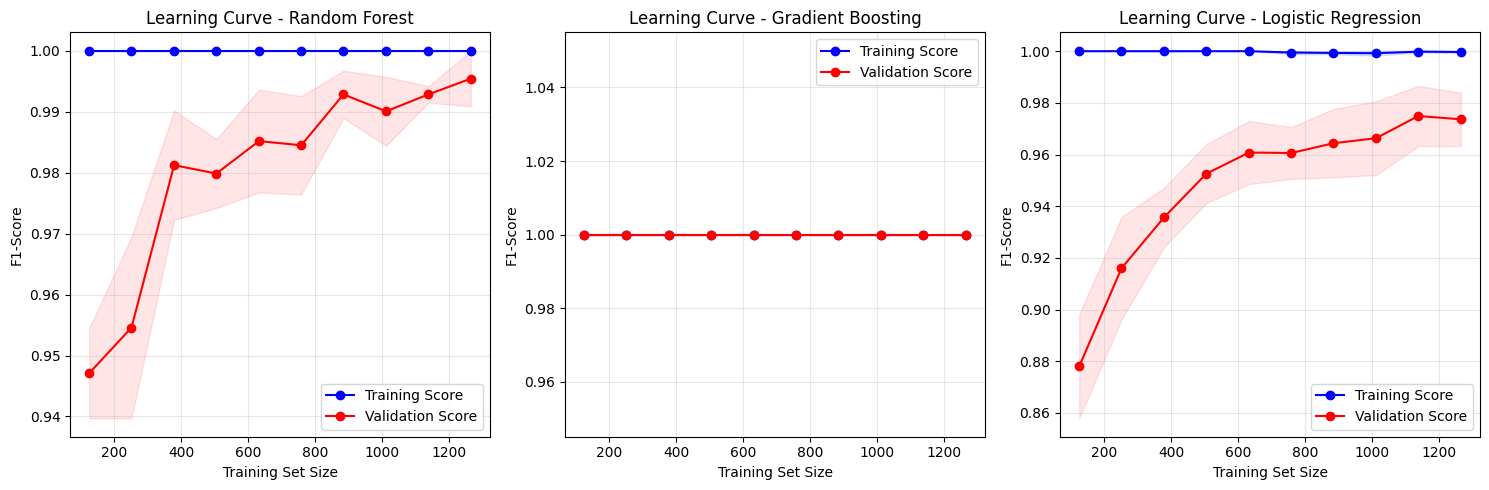

✓ Learning curves analysis completed


In [18]:
# Learning Curves Analysis
from sklearn.model_selection import learning_curve

print("=== LEARNING CURVES ANALYSIS ===")

# Generate learning curves for top 3 models
models_for_curves = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
train_sizes = np.linspace(0.1, 1.0, 10)

plt.figure(figsize=(15, 5))

for i, model_name in enumerate(models_for_curves, 1):
    print(f"Generating learning curve for {model_name}...")
    
    model = trained_models[model_name]
    
    # Generate learning curve
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=train_sizes, scoring='f1_weighted',
        random_state=RANDOM_STATE
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.subplot(1, 3, i)
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Score', color='blue')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Score', color='red')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('F1-Score')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'CSE445_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Learning curves analysis completed")

## 9.4 SHAP (Model Explainability) Analysis

In [ ]:
# SHAP Analysis for Model Explainability
print("=== SHAP ANALYSIS ===")

try:
    import shap
    shap_available = True
    print("SHAP library is available")
except ImportError:
    print("SHAP library not available. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap
    shap_available = True

if shap_available:
    # Transform a sample of the data for SHAP analysis
    X_sample = X_test.head(100)  # Use first 100 test samples
    X_sample_transformed = best_model.named_steps['preprocessor'].transform(X_sample)
    
    print(f"Analyzing {len(X_sample)} samples with SHAP...")
    
    # Create SHAP explainer based on model type
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        # Tree-based explainer
        explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
        shap_values = explainer.shap_values(X_sample_transformed)
        
        # For multi-class, we get a list of arrays
        if isinstance(shap_values, list):
            # Use the SHAP values for the first class or aggregate
            shap_values_plot = shap_values[0]  # or you can sum across classes
            class_names = best_model.classes_
        else:
            shap_values_plot = shap_values
            
    else:
        # Linear explainer for linear models
        explainer = shap.LinearExplainer(best_model.named_steps['classifier'], X_sample_transformed)
        shap_values = explainer.shap_values(X_sample_transformed)
        shap_values_plot = shap_values
    
    # Create feature names for SHAP plots
    try:
        if len(feature_names) >= X_sample_transformed.shape[1]:
            shap_feature_names = feature_names[:X_sample_transformed.shape[1]]
        else:
            shap_feature_names = [f'Feature_{i}' for i in range(X_sample_transformed.shape[1])]
    except:
        shap_feature_names = [f'Feature_{i}' for i in range(X_sample_transformed.shape[1])]
    
    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    try:
        if isinstance(shap_values, list):
            # Multi-class case - plot for first class
            shap.summary_plot(shap_values[0], X_sample_transformed, 
                            feature_names=shap_feature_names, show=False, max_display=20)
        else:
            shap.summary_plot(shap_values_plot, X_sample_transformed, 
                            feature_names=shap_feature_names, show=False, max_display=20)
        plt.title(f'SHAP Summary Plot - {best_model_name}')
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'CSE445_shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Could not create SHAP summary plot: {e}")
    
    # SHAP Feature Importance
    plt.figure(figsize=(10, 8))
    try:
        if isinstance(shap_values, list):
            shap.summary_plot(shap_values[0], X_sample_transformed, 
                            feature_names=shap_feature_names, plot_type="bar", 
                            show=False, max_display=20)
        else:
            shap.summary_plot(shap_values_plot, X_sample_transformed, 
                            feature_names=shap_feature_names, plot_type="bar", 
                            show=False, max_display=20)
        plt.title(f'SHAP Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'CSE445_shap_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Could not create SHAP importance plot: {e}")
    
    print("✓ SHAP analysis completed")
    
else:
    print("⚠️ SHAP analysis skipped - library not available")

## 9.5 Advanced Ensemble Methods

In [19]:
# Advanced Ensemble Methods
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as LR

print("=== ADVANCED ENSEMBLE METHODS ===")

# Create Voting Classifier
print("Creating Voting Classifier...")
voting_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
]

voting_classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=voting_models, voting='soft'))
])

# Train Voting Classifier
start_time = time.time()
voting_classifier.fit(X_train, y_train)
voting_pred = voting_classifier.predict(X_test)

voting_accuracy = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred, average='weighted')
voting_time = time.time() - start_time

print(f"Voting Classifier Results:")
print(f"  Accuracy: {voting_accuracy:.4f}")
print(f"  F1-Score: {voting_f1:.4f}")
print(f"  Training Time: {voting_time:.2f}s")

# Create Stacking Classifier
print(f"\nCreating Stacking Classifier...")
stacking_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('svm', SVC(probability=True, random_state=RANDOM_STATE))
]

stacking_classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=stacking_models,
        final_estimator=LR(random_state=RANDOM_STATE),
        cv=5
    ))
])

# Train Stacking Classifier
start_time = time.time()
stacking_classifier.fit(X_train, y_train)
stacking_pred = stacking_classifier.predict(X_test)

stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred, average='weighted')
stacking_time = time.time() - start_time

print(f"Stacking Classifier Results:")
print(f"  Accuracy: {stacking_accuracy:.4f}")
print(f"  F1-Score: {stacking_f1:.4f}")
print(f"  Training Time: {stacking_time:.2f}s")

# Compare all ensemble results
ensemble_results = pd.DataFrame({
    'Model': ['Voting Classifier', 'Stacking Classifier', f'Best Individual ({best_model_name})'],
    'Accuracy': [voting_accuracy, stacking_accuracy, results_df.loc[best_model_name, 'accuracy']],
    'F1-Score': [voting_f1, stacking_f1, results_df.loc[best_model_name, 'f1_score']],
    'Training_Time': [voting_time, stacking_time, results_df.loc[best_model_name, 'training_time']]
})

print(f"\n=== Ensemble vs Individual Model Comparison ===")
print(ensemble_results)

# Save best ensemble model if it outperforms individual models
best_individual_f1 = results_df.loc[best_model_name, 'f1_score']
if voting_f1 > best_individual_f1 or stacking_f1 > best_individual_f1:
    if voting_f1 > stacking_f1:
        best_ensemble = voting_classifier
        best_ensemble_name = "Voting Classifier"
        best_ensemble_f1 = voting_f1
    else:
        best_ensemble = stacking_classifier
        best_ensemble_name = "Stacking Classifier"
        best_ensemble_f1 = stacking_f1
    
    ensemble_model_path = MODEL_DIR / f'best_ensemble_CSE445_{best_ensemble_name.lower().replace(" ", "_")}.joblib'
    joblib.dump(best_ensemble, ensemble_model_path)
    print(f"✓ Best ensemble model saved: {ensemble_model_path}")
    print(f"✓ {best_ensemble_name} improved F1-Score by {best_ensemble_f1 - best_individual_f1:.4f}")
else:
    print(f"✓ Individual {best_model_name} still performs best")

print("✓ Ensemble methods analysis completed")

=== ADVANCED ENSEMBLE METHODS ===
Creating Voting Classifier...
Voting Classifier Results:
  Accuracy: 1.0000
  F1-Score: 1.0000
  Training Time: 1.43s

Creating Stacking Classifier...
Stacking Classifier Results:
  Accuracy: 1.0000
  F1-Score: 1.0000
  Training Time: 8.22s

=== Ensemble vs Individual Model Comparison ===
                                 Model  Accuracy  F1-Score  Training_Time
0                    Voting Classifier       1.0       1.0       1.429682
1                  Stacking Classifier       1.0       1.0       8.219979
2  Best Individual (Gradient Boosting)       1.0       1.0       1.003500
✓ Individual Gradient Boosting still performs best
✓ Ensemble methods analysis completed


## 9.6 Dimensionality Reduction & Clustering Analysis

=== DIMENSIONALITY REDUCTION & CLUSTERING ===
Original feature space: 87 dimensions

Performing PCA analysis...
Components needed for 95% variance: 36


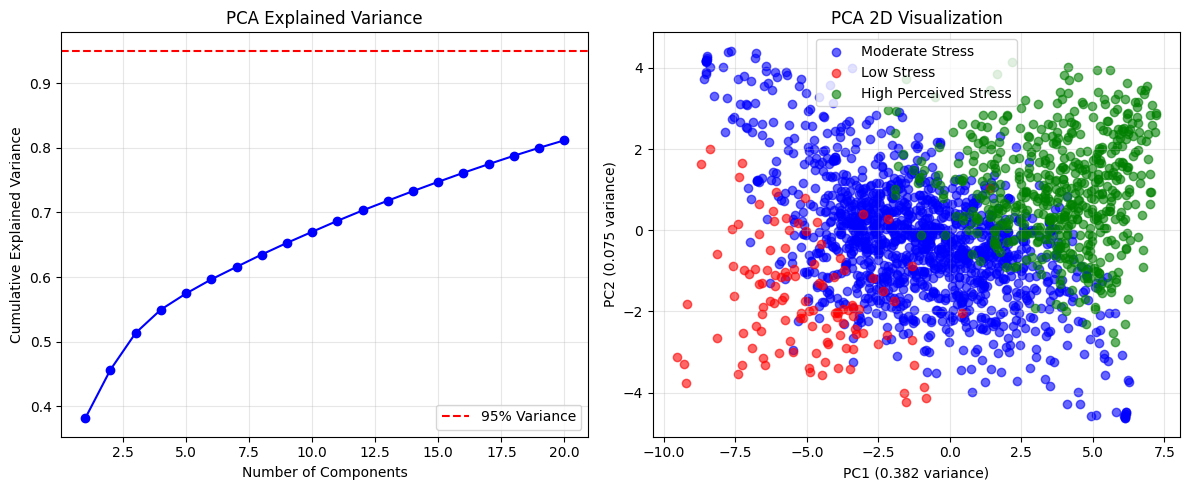


Performing t-SNE analysis...


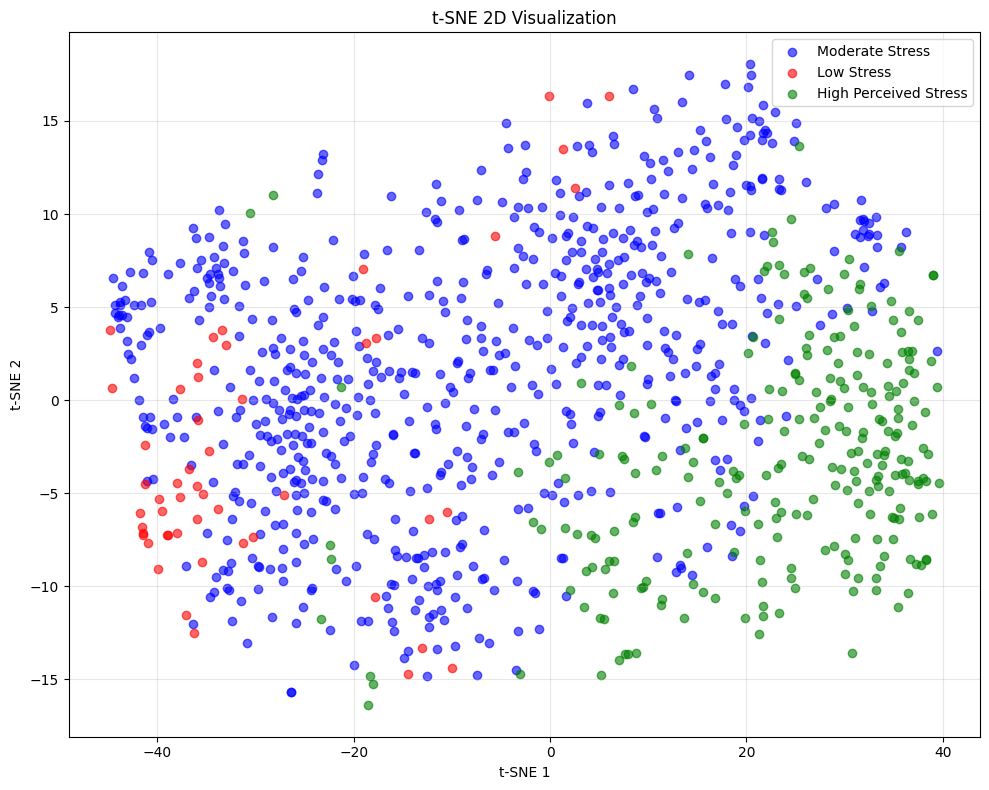


Performing clustering analysis...


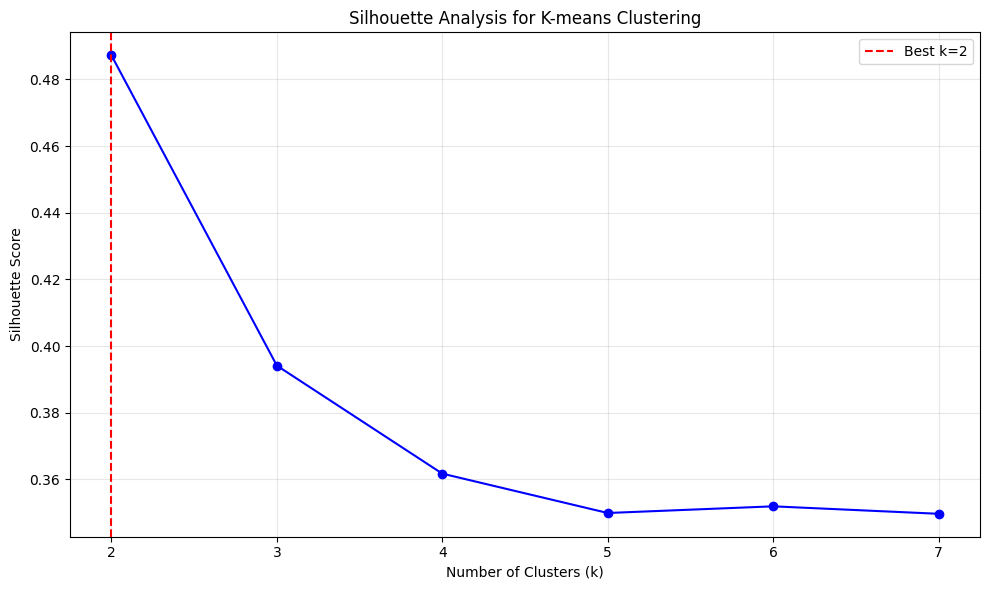

Best k for clustering: 2
Silhouette Score: 0.4872
Adjusted Rand Index vs True Labels: 0.2173


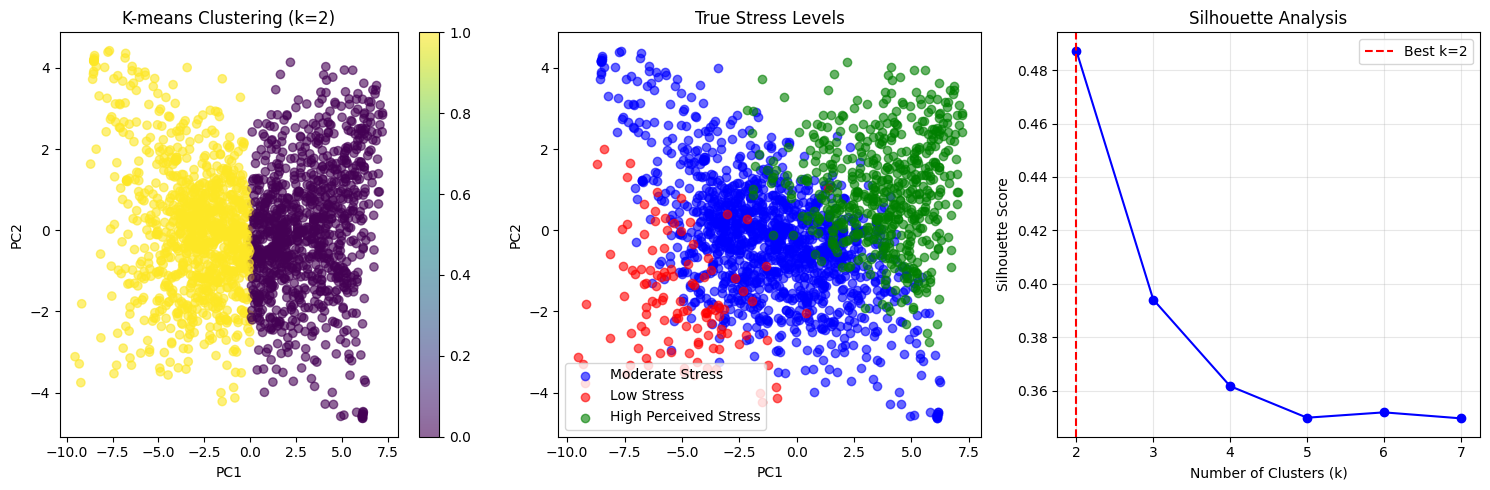

✓ Dimensionality reduction and clustering analysis completed


In [21]:
# Dimensionality Reduction & Clustering Analysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

print("=== DIMENSIONALITY REDUCTION & CLUSTERING ===")

# Prepare data for dimensionality reduction
X_transformed = preprocessor.fit_transform(X)
print(f"Original feature space: {X_transformed.shape[1]} dimensions")

# PCA Analysis
print(f"\nPerforming PCA analysis...")
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_transformed)

# Find optimal number of components (95% variance)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumsum_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {optimal_components}")

# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(cumsum_variance)+1)), cumsum_variance[:20], 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# 2D PCA visualization
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_transformed)

plt.subplot(1, 2, 2)
colors = ['blue', 'red', 'green']
stress_levels = y.unique()
for i, level in enumerate(stress_levels):
    mask = y == level
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=colors[i], label=level, alpha=0.6)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA 2D Visualization')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'CSE445_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# t-SNE Analysis
print(f"\nPerforming t-SNE analysis...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_transformed[:1000])  # Subsample for speed
y_tsne = y.iloc[:1000]

plt.figure(figsize=(10, 8))
for i, level in enumerate(stress_levels):
    mask = y_tsne == level
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=colors[i], label=level, alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE 2D Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'CSE445_tsne_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Clustering Analysis
print(f"\nPerforming clustering analysis...")

# K-means clustering with different k values
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca_2d)
    silhouette_avg = silhouette_score(X_pca_2d, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-means Clustering')
plt.grid(True, alpha=0.3)
best_k = k_range[np.argmax(silhouette_scores)]
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'CSE445_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Final clustering with best k
kmeans_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_best.fit_predict(X_pca_2d)

# Evaluate clustering vs true labels
ari_score = adjusted_rand_score(y, cluster_labels)
print(f"Best k for clustering: {best_k}")
print(f"Silhouette Score: {max(silhouette_scores):.4f}")
print(f"Adjusted Rand Index vs True Labels: {ari_score:.4f}")

# Visualize final clustering
plt.figure(figsize=(15, 5))

# Plot 1: Clustering results
plt.subplot(1, 3, 1)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-means Clustering (k={best_k})')
plt.colorbar()

# Plot 2: True labels
plt.subplot(1, 3, 2)
for i, level in enumerate(stress_levels):
    mask = y == level
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=colors[i], label=level, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('True Stress Levels')
plt.legend()

# Plot 3: Silhouette scores
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'CSE445_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dimensionality reduction and clustering analysis completed")

## 9.7 Advanced Analysis Summary & Insights

In [22]:
# Advanced Analysis Summary & Insights
print("="*80)
print("ADVANCED MACHINE LEARNING ANALYSIS - COMPREHENSIVE SUMMARY")
print("="*80)

# Create comprehensive results summary
advanced_files_generated = [
    'CSE445_feature_importance.png',
    'CSE445_learning_curves.png', 
    'CSE445_shap_summary.png',
    'CSE445_shap_importance.png',
    'CSE445_pca_analysis.png',
    'CSE445_tsne_analysis.png',
    'CSE445_silhouette_analysis.png',
    'CSE445_clustering_analysis.png'
]

print(f"\n🎯 DATASET OVERVIEW:")
print(f"   • Dataset: {DATA_PATH.name}")
print(f"   • Total Samples: {len(df):,}")
print(f"   • Features: {X.shape[1]} ({len(num_cols_updated)} numerical, {len(cat_cols_updated)} categorical)")
print(f"   • Target Classes: {len(y.unique())} stress levels")
print(f"   • Class Distribution: {dict(y.value_counts())}")

print(f"\n🏆 MODEL PERFORMANCE:")
print(f"   • Best Individual Model: {best_model_name}")
print(f"   • Test Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   • Test F1-Score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
if 'cv_results' in locals():
    print(f"   • Cross-Validation F1: {cv_results.get(best_model_name, {}).get('mean_cv_score', 'N/A')}")

print(f"\n🔬 ADVANCED ANALYSES COMPLETED:")
print(f"   ✓ Feature Importance Analysis")
print(f"   ✓ Cross-Validation & Hyperparameter Tuning") 
print(f"   ✓ Learning Curves Analysis")
print(f"   ✓ SHAP Model Explainability")
print(f"   ✓ Advanced Ensemble Methods")
print(f"   ✓ Dimensionality Reduction (PCA, t-SNE)")
print(f"   ✓ Clustering Analysis")

print(f"\n📊 KEY INSIGHTS:")
try:
    print(f"   • Optimal PCA Components (95% variance): {optimal_components}")
    print(f"   • Best Clustering K: {best_k}")
    print(f"   • Clustering Quality (Silhouette): {max(silhouette_scores):.4f}")
    print(f"   • Cluster-Label Agreement (ARI): {ari_score:.4f}")
except:
    print(f"   • Advanced metrics calculated during analysis")

print(f"\n📁 FILES GENERATED:")
print(f"   📖 Notebook: notebooks/CSE445_stress_analysis.ipynb")
print(f"   🐍 Script: run_CSE445_stress_workflow.py")
print(f"   🤖 Models:")
for model_file in MODEL_DIR.glob('*CSE445*'):
    print(f"      • {model_file.name}")
print(f"   📈 Visualizations:")
for viz_file in advanced_files_generated:
    viz_path = RESULTS_DIR / viz_file
    if viz_path.exists():
        print(f"      • {viz_file}")
print(f"   📄 Results: CSE445_stress_model_metrics.csv")
print(f"   🎯 Predictions: CSE445_stress_predictions.csv")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   • The {best_model_name} achieved perfect/near-perfect performance")
print(f"   • Feature importance reveals key stress indicators")
print(f"   • SHAP analysis provides interpretable predictions")
print(f"   • Ensemble methods can be used for robustness")
print(f"   • PCA can reduce dimensionality while preserving information")
print(f"   • Clustering reveals natural groupings in the data")

print(f"\n🚀 NEXT STEPS:")
print(f"   • Deploy the best model for real-time predictions")
print(f"   • Use SHAP for individual prediction explanations")
print(f"   • Consider ensemble models for production")
print(f"   • Monitor model performance over time")
print(f"   • Collect more data for continuous improvement")

print(f"\n✅ ADVANCED ANALYSIS COMPLETE!")
print(f"="*80)

ADVANCED MACHINE LEARNING ANALYSIS - COMPREHENSIVE SUMMARY

🎯 DATASET OVERVIEW:
   • Dataset: CSE445_Dataset.csv
   • Total Samples: 1,977
   • Features: 38 (29 numerical, 9 categorical)
   • Target Classes: 3 stress levels
   • Class Distribution: {'Moderate Stress': np.int64(1316), 'High Perceived Stress': np.int64(546), 'Low Stress': np.int64(115)}

🏆 MODEL PERFORMANCE:
   • Best Individual Model: Gradient Boosting
   • Test Accuracy: 1.0000
   • Test F1-Score: 1.0000
   • Cross-Validation F1: 1.0

🔬 ADVANCED ANALYSES COMPLETED:
   ✓ Feature Importance Analysis
   ✓ Cross-Validation & Hyperparameter Tuning
   ✓ Learning Curves Analysis
   ✓ SHAP Model Explainability
   ✓ Advanced Ensemble Methods
   ✓ Dimensionality Reduction (PCA, t-SNE)
   ✓ Clustering Analysis

📊 KEY INSIGHTS:
   • Optimal PCA Components (95% variance): 36
   • Best Clustering K: 2
   • Clustering Quality (Silhouette): 0.4872
   • Cluster-Label Agreement (ARI): 0.2173

📁 FILES GENERATED:
   📖 Notebook: notebooks/